# Lab 4.4 Emotion Classification using a fine-tuned BERT model

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

This notebook shows how you can use a BERT model that was fine-tuned for emotion detection using the GO dataset from Google.
The GO dataset consists of 58k English Reddit comments, labeled for 27 emotion categories or Neutral:

https://github.com/google-research/google-research/tree/master/goemotions

REFERENCE:
Demszky, Dorottya, Dana Movshovitz-Attias, Jeongwoo Ko, Alan Cowen, Gaurav Nemade, and Sujith Ravi. "GoEmotions: A dataset of fine-grained emotions." arXiv preprint arXiv:2005.00547 (2020).


The GO emotions are more nuanced than the six basic Ekman emotions derived from facial expressions. They are based on a diverse range of emotion data and not just facial expression:

https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html


```
LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]```


We will load a BERT language model that is finetuned for emotion detection using this *go_emotions* data set. The **pipeline** task for using this model is *sentiment-analysis*. The pipeline **sentiment-analysis** stands for **text classification** and it should be understood as the prototype for the type of classification that is carried out. In this case **text classification** assigns a label to the text as a whole and not to individual tokens. The **sentiment-analysis** pipeline can be used as an alias for using any model that is fine-tuned for text classification, regardless of the labels that have been used. The labels themselves do not carry any meaning for the model. We therefore can also use this task for topics and emotions as labels.

In [1]:
from transformers import pipeline

/opt/anaconda3/envs/hltenv/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
model_name = "bhadresh-savani/bert-base-go-emotion" 
#### Depending on the version, use:
emotion_pipeline = pipeline('sentiment-analysis', 
                    model=model_name, return_all_scores=True, device=-1)
#### Or if you get an error for return_all_scores parameter, use:
#emotion_pipeline = pipeline('sentiment-analysis', 
#                    model=model_name, top_k=None, device=-1)

Device set to use cpu
/opt/anaconda3/envs/hltenv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


We set the **model** parameter to the name of the model as specified on Huggingface.

The parameter **device** is optional. If you leave it out or set the value to "-1", you will use only your CPU. If your machine has GPUs, such as my Mac, you can set the value to the number of GPUs you want to use. If you can use the GPUs, loading and running will be a lot faster.

The **top_k** parameter is also optional but can be used how many of the top ranked classes you want to return. We set it here to "None" so that get all the classes. In older versions of transformers this parameter was called **return_all_scores** which should be set to "True" to get all results.

We now created an instance *emotion_pipeline* of a transformer pipeline in analogy of an sentiment analysis classification task that we can apply to any utterance. The pipeline will use the tokenizer of the finetuned model and feed the sentence representation to the classifier as a sequence of contextualized token representations.

In [3]:
emotion_labels = emotion_pipeline("Thanks for using it.")

In [4]:
for result in emotion_labels[0]:
    print(result)

{'label': 'admiration', 'score': 0.0007500767824240029}
{'label': 'amusement', 'score': 0.00011047106818296015}
{'label': 'anger', 'score': 9.69246102613397e-05}
{'label': 'annoyance', 'score': 0.0002597436250653118}
{'label': 'approval', 'score': 0.0011426012497395277}
{'label': 'caring', 'score': 0.00030970710213296115}
{'label': 'confusion', 'score': 0.00014959769032429904}
{'label': 'curiosity', 'score': 0.00015838850231375545}
{'label': 'desire', 'score': 0.0001385686337016523}
{'label': 'disappointment', 'score': 0.00016352151578757912}
{'label': 'disapproval', 'score': 0.0002003054687520489}
{'label': 'disgust', 'score': 5.9684312873287126e-05}
{'label': 'embarrassment', 'score': 5.588319982052781e-05}
{'label': 'excitement', 'score': 0.00018467512563802302}
{'label': 'fear', 'score': 5.239497113507241e-05}
{'label': 'gratitude', 'score': 0.9934592247009277}
{'label': 'grief', 'score': 2.022589251282625e-05}
{'label': 'joy', 'score': 0.0003203645464964211}
{'label': 'love', 'sco

Although the GO emotions are a lot more nuanced than the Ekman emotions, it is possible to map the more specific emotions to Ekman's more basic ones and even to sentiments. The next mapping from the original Github of goemotions just do that:

In [5]:
### Mapping GO_Emotions to sentiment values
sentiment_map={
"positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
"negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
"ambiguous": ["realization", "surprise", "curiosity", "confusion"]
}

### Mapping GO_Emotions to Ekman values
ekman_map={
"anger": ["anger", "annoyance", "disapproval"],
"disgust": ["disgust"],
"fear": ["fear", "nervousness"],
"joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
"sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
"surprise": ["surprise", "realization", "confusion", "curiosity"],
"neutral": ["neutral"]
}

We can now make a few simple auxiliary functions that can translate GO emotions to Ekman or to sentiment values. The functions (1) sort the predictions by their score and (2) select the scores above a certain threshold. Only the ones above the threshold are mapped (3).

In [6]:
### Sort a list of results in JSON format by the value of the score element
def sort_predictions(predictions):
    return sorted(predictions, key=lambda x: x['score'], reverse=True)


### Use a mapping to get a dictionary of the mapped GO_emotion scores above the thereshold
def get_mapped_scores(emotion_map, go_emotion_scores, threshold):
    mapped_scores = {}
    for prediction in go_emotion_scores[0]:
        if prediction['score']>=threshold:
            go_emotion=prediction['label']
            for key in emotion_map:
                if go_emotion in emotion_map[key]:
                    if not key in mapped_scores:
                        mapped_scores[key]= [prediction['score']]
                    else:
                        mapped_scores[key].append(prediction['score'])
    return mapped_scores

### Get the averaged score for an emotion or sentiment from the GO_emotion scores above a threshold
### mapped according to the emotion_map
def get_averaged_mapped_scores_by_threshold(emotion_map, go_emotion_scores, threshold):
    averaged_mapped_scores = []
    mapped_scores = get_mapped_scores(emotion_map, go_emotion_scores, threshold)
    for emotion in mapped_scores:
        lst = mapped_scores[emotion]
        averaged_score= sum(lst)/len(lst)
        averaged_mapped_scores.append({'label':emotion, 'score':averaged_score})
    return sort_predictions(averaged_mapped_scores)

Using these function, we can print the averaged Ekman and the averaged sentiment score for any GO emotion classifition result:

In [7]:
threshold = 0.05
print('Threshold', threshold)
ekman_labels = get_averaged_mapped_scores_by_threshold(ekman_map, emotion_labels, threshold)
for ekman in ekman_labels:
    print(ekman)

print()
threshold = 0.0001
print('Threshold', threshold)
ekman_labels = get_averaged_mapped_scores_by_threshold(ekman_map, emotion_labels, threshold)
for ekman in ekman_labels:
    print(ekman)

Threshold 0.05
{'label': 'joy', 'score': 0.9934592247009277}

Threshold 0.0001
{'label': 'joy', 'score': 0.09065005534317937}
{'label': 'neutral', 'score': 0.000802881782874465}
{'label': 'anger', 'score': 0.00023002454690868035}
{'label': 'surprise', 'score': 0.00021510613078135066}
{'label': 'sadness', 'score': 0.00016352151578757912}


In [8]:
threshold = 0.05
print('Threshold', threshold)
sentiment_scores = get_averaged_mapped_scores_by_threshold(sentiment_map, emotion_labels, threshold)
for sentiment in sentiment_scores:
    print(sentiment)

print()
threshold = 0.0001
print('Threshold', threshold)
sentiment_scores = get_averaged_mapped_scores_by_threshold(sentiment_map, emotion_labels, threshold)
for sentiment in sentiment_scores:
    print(sentiment)

Threshold 0.05
{'label': 'positive', 'score': 0.9934592247009277}

Threshold 0.0001
{'label': 'positive', 'score': 0.09065005534317937}
{'label': 'ambiguous', 'score': 0.00021510613078135066}
{'label': 'negative', 'score': 0.00020785686986831328}


## Applying the GO Classifier to Llama conversations

Remember that you has a conversation with Llama in the first week of the course. You saved this conversation to a JSON file on disk. Now is the time to load this JSON file again and to apply the GO emotion classifier to it.

We will load the JSOn file into a Pandas dataframe because it is easier to view the results. Pandas has a specific **read_json** function for this.

In [9]:
import pandas as pd

In [10]:
annotation_file = "/Users/piek/Desktop/t-MA-HLT-introduction-2025/ma-hlt-labs/lab1.chat/annotation/chats_2024/adjudicated_annotations.json"
df = pd.read_json(annotation_file)
df.head()

,utterance,speaker,turn_id,Annotator,Gold,Votes,Annotators,Adjudication
0,Hi there! Going going well!,Raul,4,Pawel,neutral,"[neutral, joy, joy]","[Pawel, Leo Mylonadis, Matt]",joy
1,From hike? Do yo want to convince me you're a ...,Raul,6,Pawel,neutral,"[neutral, neutral, surprise]","[Pawel, Leo Mylonadis, Matt]",neutral
2,I hope that your dried llama food isn't anythi...,Raul,8,Pawel,disgust,"[disgust, disgust, neutral]","[Pawel, Leo Mylonadis, Matt]",disgust
3,Don't wink wink at me!,Raul,10,Pawel,anger,"[anger, anger, anger]","[Pawel, Leo Mylonadis, Matt]",anger
4,I think all the LLM hype is quite suspicious!,Raul,12,Pawel,anger,"[anger, fear, surprise]","[Pawel, Leo Mylonadis, Matt]",anger


Now we can easily get the data from the columns.

In [11]:
# THE CODE TO GET THE TEST TEXTS AND LABELS
test_instances =df['utterance']
test_labels = df['Adjudication']
print(len(test_instances))
print(len(test_labels))

523
523


The next code takes each utterance from the **test_instances** and applies the GO-pipeline to get the predictions for the emotion_labels. These predictions are a list of lists, so we give the inner list to (1) sort the predictions and (2) take the highest scoring predictions and its score as the **go_emotion** result.

The other two blocks of code in the for loop, take the same emotion label results but map these to Ekman values using the mapping and the threshold.

All the results are collected in separate lists.

In [12]:
threshold = 0.05

go_ekman_emotions = []
go_ekman_scores = []
go_emotions = []
go_scores = []

counter = 0
for utterance in test_instances:
    counter += 1
    if counter%20 == 0:
        print('Processed utterances', counter)
    emotion_labels = emotion_pipeline(utterance)
    sorted_emotion_labels = sort_predictions(emotion_labels[0])
    go_emotions.append(sorted_emotion_labels[0]['label'])
    go_scores.append(sorted_emotion_labels[0]['score'])

    ekman_labels = get_averaged_mapped_scores_by_threshold(ekman_map, emotion_labels, threshold)
    if ekman_labels:
        go_ekman_emotions.append(ekman_labels[0]['label'])
        go_ekman_scores.append(ekman_labels[0]['score'])
    else:
        #### none of the labels scored above the threshold
        go_ekman_emotions.append('None')
        go_ekman_scores.append(0)


Processed utterances 20
Processed utterances 40
Processed utterances 60
Processed utterances 80
Processed utterances 100
Processed utterances 120
Processed utterances 140
Processed utterances 160
Processed utterances 180
Processed utterances 200
Processed utterances 220
Processed utterances 240
Processed utterances 260
Processed utterances 280
Processed utterances 300
Processed utterances 320
Processed utterances 340
Processed utterances 360
Processed utterances 380
Processed utterances 400
Processed utterances 420
Processed utterances 440
Processed utterances 460
Processed utterances 480
Processed utterances 500
Processed utterances 520


We can now add the output to the pandas frame as separate columns, assuming that the values correspond to the rows.

In [13]:
df['Go_Ekman']=go_ekman_emotions
df['Go_EkmanScore']=go_ekman_scores
df['Go']=go_emotions
df['GoScore']=go_scores
df.head()

,utterance,speaker,turn_id,Annotator,Gold,Votes,Annotators,Adjudication,Go_Ekman,Go_EkmanScore,Go,GoScore
0,Hi there! Going going well!,Raul,4,Pawel,neutral,"[neutral, joy, joy]","[Pawel, Leo Mylonadis, Matt]",joy,neutral,0.343307,neutral,0.343307
1,From hike? Do yo want to convince me you're a ...,Raul,6,Pawel,neutral,"[neutral, neutral, surprise]","[Pawel, Leo Mylonadis, Matt]",neutral,neutral,0.326313,curiosity,0.426074
2,I hope that your dried llama food isn't anythi...,Raul,8,Pawel,disgust,"[disgust, disgust, neutral]","[Pawel, Leo Mylonadis, Matt]",disgust,joy,0.789635,optimism,0.789635
3,Don't wink wink at me!,Raul,10,Pawel,anger,"[anger, anger, anger]","[Pawel, Leo Mylonadis, Matt]",anger,neutral,0.264323,neutral,0.264323
4,I think all the LLM hype is quite suspicious!,Raul,12,Pawel,anger,"[anger, fear, surprise]","[Pawel, Leo Mylonadis, Matt]",anger,neutral,0.398782,neutral,0.398782


It is easy to get a list of gold labels and a list of predictions from this table and to use **sklearn** to evaluate.

In [14]:
predictions = df['Go_Ekman']
for pair in zip(test_labels,predictions):
    print(pair)

('joy', 'neutral')
('neutral', 'neutral')
('disgust', 'joy')
('anger', 'neutral')
('anger', 'neutral')
('neutral', 'neutral')
('anger', 'neutral')
('sadness', 'neutral')
('sadness', 'neutral')
('neutral', 'neutral')
('anger', 'neutral')
('neutral', 'neutral')
('anger', 'neutral')
('neutral', 'neutral')
('neutral', 'neutral')
('anger', 'anger')
('neutral', 'disgust')
('disgust', 'neutral')
('neutral', 'neutral')
('neutral', 'neutral')
('sadness', 'surprise')
('sadness', 'anger')
('anger', 'anger')
('anger', 'neutral')
('sadness', 'neutral')
('anger', 'neutral')
('neutral', 'neutral')
('neutral', 'surprise')
('neutral', 'surprise')
('anger', 'joy')
('anger', 'anger')
('neutral', 'neutral')
('neutral', 'joy')
('neutral', 'neutral')
('neutral', 'joy')
('anger', 'anger')
('neutral', 'neutral')
('neutral', 'joy')
('neutral', 'neutral')
('neutral', 'neutral')
('neutral', 'neutral')
('disgust', 'neutral')
('neutral', 'neutral')
('neutral', 'joy')
('neutral', 'neutral')
('neutral', 'neutral')
(

<Axes: ylabel='count'>

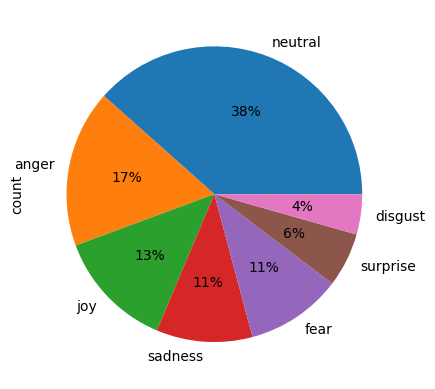

In [15]:
gold = df.Gold.value_counts()
gold.plot(kind='pie', autopct='%1.0f%%')

To make sure we use the corect labels in the evaluation reports, we take all the labels from the Gold column and all the predictions and make it a unique set in alphabetic order. 

In [16]:
labels = list(test_labels)+list(predictions)
label_set = sorted(set(labels))
print(label_set)

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


We can now use this label_set for both the classification report and the confusion matrix.

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

predictions = df['Go_Ekman']
report = classification_report(test_labels,predictions ,digits = 7, target_names=label_set)
print('GO EKMAN mapping ----------------------------------------------------------------')
print('Mapping threshold', threshold)

print(report)

GO EKMAN mapping ----------------------------------------------------------------
Mapping threshold 0.05
              precision    recall  f1-score   support

       anger  0.6600000 0.3510638 0.4583333        94
     disgust  0.6000000 0.1363636 0.2222222        22
        fear  0.8333333 0.4716981 0.6024096        53
         joy  0.3935484 0.7721519 0.5213675        79
     neutral  0.5806452 0.5714286 0.5760000       189
     sadness  0.7812500 0.4385965 0.5617978        57
    surprise  0.2461538 0.5517241 0.3404255        29

    accuracy                      0.5181644       523
   macro avg  0.5849901 0.4704324 0.4689366       523
weighted avg  0.5963836 0.5181644 0.5197835       523



Confusion matrix SVM
[[ 33   1   1  16  31   4   8]
 [  5   3   1   6   7   0   0]
 [  2   0  25  11   6   1   8]
 [  0   0   0  61  13   1   4]
 [  6   1   1  47 108   1  25]
 [  4   0   1  10  13  25   4]
 [  0   0   1   4   8   0  16]]


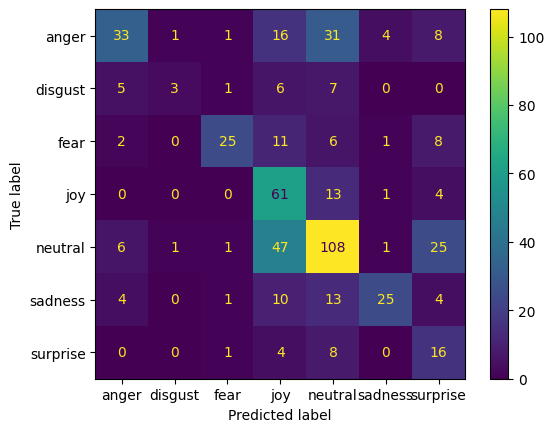

In [18]:
print('Confusion matrix SVM')
cf_matrix = confusion_matrix(test_labels,predictions)
print(cf_matrix)
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set)
display.plot()

We can see here that the most problematic class is **neutral** which has some false negatives falsely outputting joy and surprise and substantial amount false positives for utterances labeled as anger.

# End of this notebook